# 实战 Kaggle 比赛：预测房价

实现几个函数来方便下载数据

In [1]:
import sys
sys.path.append('..')

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests
from mindspore import Tensor
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

[WARNING] CORE(308750,ffff990d1640,python):2025-12-14-22:19:41.055.585 [mindspore/core/utils/ms_context.cc:533] GetJitLevel] Set jit level to O2 for rank table startup method.
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'n

使用`pandas`读入并处理数据

In [3]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
from d2l import mindspore as d2l
import mindspore
from mindspore import nn, value_and_grad, mint
import numpy as np
import pandas as pd

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应标签

In [4]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID，
我们将其从数据集中删除

In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

将所有缺失的值替换为相应特征的平均值。
通过将特征重新缩放到零均值和单位方差来标准化数据

In [6]:
#若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值。
我们用独热编码替换它们

In [7]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

从`pandas`格式中提取NumPy格式

In [8]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].values.astype(np.float32)
test_features = all_features[n_train:].values.astype(np.float32)
train_labels = train_data.SalePrice.values.reshape(-1, 1).astype(np.float32)

训练

In [9]:
mse_loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.SequentialCell([nn.Dense(in_features,1)])
    return net

我们更关心相对误差$\frac{y - \hat{y}}{y}$，
解决这个问题的一种方法是用价格预测的对数来衡量差异

In [10]:
def log_rmse(net, features, labels):
    clipped_preds = d2l.clip_by_value(net(features), 1, float('inf'))
    rmse = d2l.sqrt(mse_loss(d2l.log(clipped_preds),
                             d2l.log(labels)))
    return rmse.asnumpy()

我们的训练函数将借助Adam优化器

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = nn.Adam(net.trainable_params(),
                        learning_rate = learning_rate,
                        weight_decay = weight_decay)

    # 定义前向传播函数
    def forward_fn(x, y):
        z = net(x)
        loss = mse_loss(z, y)
        return loss, z

    # 获取梯度函数
    grad_fn = value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # 定义模型单步训练
    def train_one_step(X, Y):
        X = X.astype(mstype.float32)
        Y = Y.astype(mstype.float32)
        (loss, _), grads = grad_fn(X, Y)
        optimizer(grads)
        return loss

    for epoch in range(num_epochs):
        for X, y in train_iter.create_tuple_iterator():
            l = train_one_step(X, y)
        train_ls.append(log_rmse(net, d2l.tensor(train_features, dtype=mstype.float32), d2l.tensor(train_labels, dtype=mstype.float32)))
        if test_labels is not None:
            test_ls.append(log_rmse(net, d2l.tensor(test_features), d2l.tensor(test_labels)))
    return train_ls, test_ls

K折交叉验证

In [12]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate([X_train, X_part], 0)
            y_train = np.concatenate([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [13]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

In [ ]:
import mindspore as ms
from mindspore import dtype as mstype

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

[WARNING] DEVICE(308750,fffdfffff120,python):2025-12-14-22:20:16.757.600 [mindspore/ccsrc/plugin/ascend/res_manager/mem_manager/ascend_memory_adapter.cc:127] Initialize] Free memory size is less than half of total memory size.Device 0 Device MOC total size:31675383808 Device MOC free size:1906348032 may be other processes occupying this card, check as: ps -ef|grep python


fold 1, train log rmse 0.170440, valid log rmse 0.157004
fold 2, train log rmse 0.162182, valid log rmse 0.191373


提交你的Kaggle预测

训练log rmse：0.162302


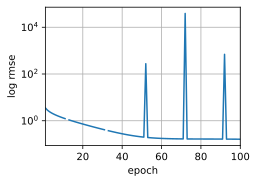

In [37]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(d2l.tensor(test_features)).asnumpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../data/submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)